In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
from scipy.integrate import odeint

import numpy as np
import time
#from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:2


In [2]:
tstart= 0 
tstop= 60 

increment = 0.1 
# Initial condition
x_init= [0,0] 

t = np.arange(tstart,tstop+1,increment)

c = 1 # Damping constant 
k = 0.01 # Stiffness of the spring
m = 5 # Mass 
F0 = 100

def mydiff(x, t):    
    F =F0
    
    dx1dt = x[1] 
    dx2dt = (F -c*x[1] -k*x[0])/m
    dxdt= [dx1dt, dx2dt] 
    
    return dxdt 

x_full_sol = odeint(mydiff, x_init, t) 

x_sol = x_full_sol[:,0]
v_sol = x_full_sol[:,1] 

In [3]:
level = "high"
label = "1D_SMD_tanhs_" + level

loss_thresh = 0.005

t_test = t.reshape(-1,1)
t_test_tensor = torch.from_numpy(t_test).float().to(device)

# bc1_t = t[0].reshape(-1,1)
# bc1_x = x_sol[0].reshape(-1,1)
# t_bc1_train = torch.from_numpy(bc1_t).float().to(device)
# x_bc1_train = torch.from_numpy(bc1_x).float().to(device)
x_mean = np.mean(x_sol.reshape(-1,1))
x_std  = np.mean(x_sol.reshape(-1,1))                
bc1_t = t.reshape(-1,1)
bc1_x = (x_sol-x_mean).reshape(-1,1)/x_std
t_bc1_train = torch.from_numpy(bc1_t).float().to(device)
x_bc1_train = torch.from_numpy(bc1_x).float().to(device)


bc2_t = t[0].reshape(-1,1)
t_bc2_train = torch.from_numpy(bc2_t).float().to(device)
bc2_val = v_sol[0].reshape(-1,1)
bc2_val =torch.from_numpy(bc2_val).float().to(device)

t_test = t.reshape(-1,1)
t_test_tensor = torch.from_numpy(t_test).float().to(device)
x_true = x_sol
x_true_norm = np.linalg.norm(x_true,2)

# Domain bounds
lb = np.array(t[0]) 
ub = np.array(t[-1]) 

#torch.autograd.set_detect_anomaly(True)

In [4]:
def colloc_pts(N_f,seed):
    
    t01 = np.array([[0.0, 1.0]])
    sampling = LHS(xlimits=t01,random_state =seed)

    t_coll = lb + (ub-lb)*sampling(N_f)
    # t_coll = np.vstack((t_coll,)) # append training points to collocation points 

    return t_coll

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        
        self.k = Parameter(torch.tensor(0.0))
        self.k.requiresGrad = True
        self.c = Parameter(torch.tensor(0.0))
        self.c.requiresGrad = True
        self.m = Parameter(torch.tensor(0.0))
        self.m.requiresGrad = True
        
    'forward pass'
    def forward(self,t):
        if torch.is_tensor(t) != True:         
            t = torch.from_numpy(t)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        t = 2.0*(t - l_b)/(u_b - l_b) - 1.0 #feature scaling
        
        #convert to float
        a = t.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,t,x):
                
        loss_bc1 = self.loss_function(self.forward(t), x)
                
        return loss_bc1
    
    def loss_BC2(self,t_bc2,bc2_val):
        g = t_bc2.clone()             
        g.requires_grad = True
        x = self.forward(g)    
            
        x_t = autograd.grad(x,g,torch.ones([t_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dx_dt = x_t[:,[0]]
        
        bc2 = dx_dt/x_std
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self,t_coll,f_hat):
             
        g = t_coll.clone()             
        g.requires_grad = True
  
        x = self.forward(g) 

        x_t = autograd.grad(x,g,torch.ones([t_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        x_tt = autograd.grad(x_t,g,torch.ones(t_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dx_dt = x_t[:,[0]]
        
        dx2_d2t = x_tt[:,[0]]
        
        f = self.m*dx2_d2t/x_std + self.c*dx_dt/x_std + self.k*x/x_std - F0
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,t_bc1,x_bc1,t_bc2,bc2_val,t_coll,f_hat):

        loss_bc1 = self.loss_BC1(t_bc1,x_bc1)
        loss_bc2 = self.loss_BC2(t_bc2,bc2_val)
        loss_f = self.loss_PDE(t_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        x_pred = self.forward(t_test_tensor)
        x_pred = x_pred.cpu().detach().numpy()
        
        x_pred = x_pred*x_std + x_mean

        return x_pred
    
    def test_loss(self):
        x_pred = self.test()
        
        test_mse = np.mean(np.square(x_pred.reshape(-1,1) - x_true.reshape(-1,1)))
        test_re = np.linalg.norm(x_pred.reshape(-1,1) - x_true.reshape(-1,1),2)/x_true_norm
        
        return test_mse, test_re

In [6]:
def train_step(t_bc1_train,x_bc1_train,t_bc2_train,bc2_val,t_coll,f_hat):
    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(t_bc1_train,x_bc1_train,t_bc2_train,bc2_val,t_coll,f_hat)
        loss.backward()
        
        return loss

    optimizer.step(closure)

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)
    m_val.append(PINN.m.cpu().detach().numpy())
    k_val.append(PINN.k.cpu().detach().numpy())
    c_val.append(PINN.c.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_model(max_iter,rep):
    print(rep) 
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0

    t_coll = colloc_pts(N_f,rep*11)
    t_coll =  torch.from_numpy(t_coll).float().to(device)
    
    f_hat = torch.zeros(t_coll.shape[0],1).to(device)
    for i in range(max_iter):      
        train_step(t_bc1_train,x_bc1_train,t_bc2_train,bc2_val,t_coll,f_hat)
         
        loss_np = PINN.loss(t_bc1_train,x_bc1_train,t_bc2_train,bc2_val,t_coll,f_hat).cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1       
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test RE",test_re_loss[-1],"c",PINN.c.cpu().detach().numpy(),"k",PINN.k.cpu().detach().numpy(),"m",PINN.m.cpu().detach().numpy())
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 200

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
m_full = []
k_full = []
c_full = []
elapsed_time= np.zeros((max_reps,1))
time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):   
    train_loss = []
    test_mse_loss = []
    test_re_loss = []   
    beta_val = []
    m_val = []
    k_val = []
    c_val = []

    torch.manual_seed(reps*36)
    N_f = 10000 #Total number of collocation points

    layers = np.array([1,50,50,50,1]) #9 hidden layers
    PINN = Sequentialmodel(layers)

    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())

    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.25, 
                                max_iter = 10, 
                                max_eval = 15, 
                                tolerance_grad = 1e-6, 
                                tolerance_change = 1e-6, 
                                history_size = 100, 
                                line_search_fn = 'strong_wolfe')



    train_model(max_iter,reps)


    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)
    m_full.append(m_val)
    k_full.append(k_val)
    c_full.append(c_val)
    


    print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "beta": beta_full,"m": m_full,"k": k_full,"c": c_full, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 10000.002 Test RE 0.034208097760171724 c 0.0018465831 k 5.0723298e-05 m -4.7584173e-08
1 Train Loss 10000.001 Test RE 0.026942650284667212 c 0.002492594 k 6.977424e-05 m -8.1778815e-08
2 Train Loss 10000.001 Test RE 0.02526602612900026 c 0.0028288038 k 7.985038e-05 m -1.0300143e-07
3 Train Loss 10000.001 Test RE 0.024270765922213482 c 0.0031735161 k 8.99505e-05 m -1.2709302e-07
4 Train Loss 10000.001 Test RE 0.023681710814539233 c 0.0035279214 k 0.000100534206 m -1.5438728e-07
5 Train Loss 10000.001 Test RE 0.023328738393035005 c 0.0038951442 k 0.00011135861 m -1.8523826e-07
6 Train Loss 10000.001 Test RE 0.02311055301593934 c 0.004281504 

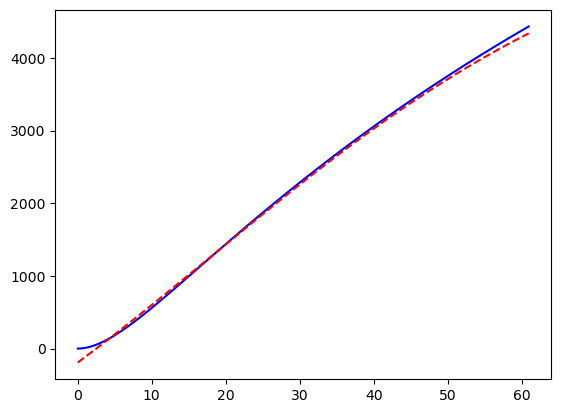

In [10]:
x_pred = PINN.test()
plt.plot(t,x_true,'b')
plt.plot(t,x_pred,'r--')